# Lending Club Loan Data Modeling

In this section we will attempt to determine the best model to predict whether or not a borrower will default in the Lending Club Loan data.

We will start with a **_Logistic Regresion_** model, using **_Forward Selection_** to determine the features. We will then try a **_Support Vector Machine_**, **_Decision Tree_** and **_Random Forest_**. 

After we'll wrap it all up with a summary of what we have learned.

First, let's import a butt load of packages per usual!

In [2]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Cleaning

In [116]:
def features_from_excel():
    lc_dd = pd.read_excel(r'data/LCDataDictionary.xlsx')
    qstr = 'Include == 1'
    cols = [x.strip() for x in lc_dd.query(qstr).LoanStatNew.values.tolist()]
    cols.remove('id')
    return cols

def loan_status_filter(input_df):
    df = input_df.copy()
    loan_status_lst = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
    mask = df.loan_status.isin(loan_status_lst)
    return df.loc[mask, :]

def make_dummy(input_df, column):
    df = input_df.copy()
    dummies = (df.loc[:, [column]]
               .pipe(pd.get_dummies))
    return df.join(dummies).drop(column, axis=1)

def mcnulty_preprocessing():
    print('Initiating MAXIMUM data munging power')
    df = (pd.read_csv('data/loan.csv', low_memory=False)
          .set_index('id')
          .pipe(loan_status_filter)
          .query('application_type == "INDIVIDUAL"')
          .loc[:, features_from_excel()]
          .assign(issue_d=lambda x: x.issue_d.astype('datetime64'),
                  default=lambda x: np.where(x.loan_status=='Fully Paid', 0, 1),
                  term=lambda x: x.term.str.strip(),
                  emp_length=lambda x: x.emp_length.fillna('Not provided'),
                  loan_amnt_k=lambda x: x.loan_amnt.div(1000),
                  annual_inc_k=lambda x: x.annual_inc.div(1000)))
    print('Luther Preprocessing Successful Woo Woo!\n')
    return df

In [117]:
fname = os.path.join('data', 'loan_cleaned_2019-08-19T20.20.43.csv')
df = mcnulty_preprocessing()

Initiating MAXIMUM data munging power
Luther Preprocessing Successful Woo Woo!



# Single Feature Logistic Regressions

In [4]:
independents = [
    ['dti'],
    ['int_rate'],
    ['annual_inc'],
    ['loan_amnt'],
    ['revol_bal'],
    ['term_36 months', 'term_60 months'],
    ['delinq_2yrs'],
    ['home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
     'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
    ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
    ['purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational',
     'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical',
     'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
     'purpose_vacation', 'purpose_wedding'],
    ['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
     'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
     'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_Not provided']
]
dependent = 'default'

In [6]:
def results_to_df(results):
    col_ord = ['model_type', 'features', 'degree', 
               'train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score', 
               'true_negatives', 'false_positives', 'false_negatives', 'true_positives'] 
    return (pd.DataFrame(results)
            .reindex(columns=col_ord)
            .sort_values('test_accuracy', ascending=False))

def scores_formatted(input_df):
    df = input_df.copy()
    scores = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score']
    for s in scores:
        df[s] = df[s].map('{:0.2%}'.format)
    gross_scores = ['true_negatives', 'false_positives', 'false_negatives', 'true_positives']
    for gs in gross_scores:
        df[gs] = df[gs].map('{:,.0f}'.format)
    return df
    
def log_clf_model(results, model, model_type, X, y, features, degree=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                        stratify=y)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    y_hat = model.predict(X_test)
    precision = metrics.precision_score(y_test, y_hat)
    recall = metrics.recall_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    record = {'model_type': model_type,
              'features': features,
              'degree': degree,
              'train_accuracy': train_accuracy,
              'test_accuracy': test_accuracy,
              'precision': precision,
              'recall': recall,
              'f1_score': f1,
              'true_negatives': tn,
              'false_positives': fp,
              'false_negatives': fn,
              'true_positives': tp}
    results.append(record)

In [139]:
results = list()
for variable in independents:
    X, y = df.loc[:, variable], df.loc[:, dependent]
    clf = LogisticRegression(solver='lbfgs')
    if len(variable) > 1:
        log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
    else:
        for degree in range(1, 4):
            if degree == 1:
                clf = LogisticRegression(solver='lbfgs')
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
            else:
                clf = Pipeline([('poly', PolynomialFeatures(degree)), 
                                ('clf', LogisticRegression(solver='lbfgs'))])
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
4,Logistic Regression,[int_rate],2,78.16%,78.16%,55.56%,0.04%,0.09%,"41,541",4,"11,606",5
0,Logistic Regression,[dti],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
1,Logistic Regression,[dti],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
22,Logistic Regression,"[emp_length_1 year, emp_length_10+ years, emp_length_2 years, emp_length_3 years, emp_length_4 years,...",1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
21,Logistic Regression,"[purpose_car, purpose_credit_card, purpose_debt_consolidation, purpose_educational, purpose_home_impr...",1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
20,Logistic Regression,"[grade_A, grade_B, grade_C, grade_D, grade_E, grade_F, grade_G]",1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
19,Logistic Regression,"[home_ownership_ANY, home_ownership_MORTGAGE, home_ownership_NONE, home_ownership_OTHER, home_ownersh...",1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
18,Logistic Regression,[delinq_2yrs],3,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
17,Logistic Regression,[delinq_2yrs],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
15,Logistic Regression,"[term_36 months, term_60 months]",1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0


We can see that all our models except 2 are guess 100 percent non-default. This is common with imbalanced classes. We are basically dealing with a high-bias problem here. We need to add features to **_reduce bias_** and **_add variance_**.

We'll start slow by adding only one additional feature.

# Logistic Regression with Two Features and Polynomials

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

def unpack_list(lst_2d):
    return list(itertools.chain.from_iterable(lst_2d))

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict.loc[:, self.key]
    
def poly_pipeline(features, degree):
    poly_steps = [('selector', ItemSelector(key=features)),
                  ('poly', PolynomialFeatures(degree=degree, include_bias=False))]
    pipeline = Pipeline(poly_steps)
    return pipeline

def dummy_pipeline(feature_name):
    feature = [feature_name]
    steps = [('selector', ItemSelector(key=feature)),
             ('enc', OneHotEncoder())]
    pipeline = Pipeline(steps)
    return pipeline

def feature_transformer_list(features, degree):
    transformer_list = list()
    numerics = [x for x in features if independents[x] == 'numeric']
    if numerics:
        numeric_trans = ('numeric', poly_pipeline(numerics, degree))
        transformer_list.append(numeric_trans)
    dummy_vars = [x for x in features if independents[x] == 'dummy']
    if dummy_vars:
        dummy_steps = list()
        for dummy in dummy_vars:
            step = ('{}_enc'.format(dummy), dummy_pipeline(dummy))
            dummy_steps.append(step)
        transformer_list += dummy_steps
    return transformer_list

def clf_pipeline(clf, features, degree):
    transformer_list = feature_transformer_list(features, degree)
    return Pipeline([('union', FeatureUnion(transformer_list=transformer_list)),
                     ('clf', clf)])

In [149]:
independents = {'dti': 'numeric',
                'int_rate': 'numeric',
                'annual_inc': 'numeric',
                'loan_amnt': 'numeric',
                'revol_bal': 'numeric',
                'delinq_2yrs': 'numeric',
                'term': 'dummy',
                'home_ownership': 'dummy',
                'grade': 'dummy',
                'purpose': 'dummy',
                'emp_length': 'dummy'}
dependent = 'default'

In [155]:
results = list()
for features_tuple in itertools.combinations(list(independents.keys()), 2):
    features = list(features_tuple)
    if independents[features[0]] == 'dummy' and independents[features[1]] == 'dummy':
        clf = LogisticRegression(solver='lbfgs')
        pipeline = clf_pipeline(clf, features, degree)
        log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, 1)
    else: 
        for degree in range(1, 4):
            clf = LogisticRegression(solver='lbfgs')
            pipeline = clf_pipeline(clf, features, degree)
            log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
1,Logistic Regression,"[dti, int_rate]",2,78.31%,78.33%,56.25%,3.57%,6.71%,"41,223",322,"11,197",414
22,Logistic Regression,"[dti, grade]",2,78.25%,78.31%,57.04%,2.76%,5.26%,"41,304",241,"11,291",320
21,Logistic Regression,"[dti, grade]",1,78.28%,78.29%,55.28%,3.29%,6.21%,"41,236",309,"11,229",382
0,Logistic Regression,"[dti, int_rate]",1,78.20%,78.26%,51.92%,6.62%,11.75%,"40,833",712,"10,842",769
55,Logistic Regression,"[int_rate, emp_length]",2,78.15%,78.18%,53.67%,0.82%,1.61%,"41,463",82,"11,516",95
15,Logistic Regression,"[dti, term]",1,78.18%,78.17%,51.63%,0.82%,1.61%,"41,456",89,"11,516",95
16,Logistic Regression,"[dti, term]",2,78.17%,78.16%,50.44%,1.96%,3.76%,"41,322",223,"11,384",227
17,Logistic Regression,"[dti, term]",3,78.17%,78.16%,50.33%,1.95%,3.75%,"41,322",223,"11,385",226
143,Logistic Regression,"[grade, emp_length]",1,78.14%,78.16%,50.58%,1.13%,2.21%,"41,417",128,"11,480",131
45,Logistic Regression,"[int_rate, home_ownership]",1,78.11%,78.16%,50.07%,5.79%,10.38%,"40,875",670,"10,939",672


## Visualization of Best Model

In [202]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
sns.set(style="darkgrid")
%matplotlib inline

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x*1e-6)
mil_fmt = FuncFormatter(millions)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)
k_fmt = FuncFormatter(thousands)

def percent(x, pos):
    return '{:,.2%}'.format(x)
percent_formatter = FuncFormatter(percent)

In [205]:
def plot_estimator(estimator, X, y, poly):
    x_min, x_max = X.iloc[:,0].min() -1, X.iloc[:,0].max() +.1
    y_min, y_max = X.iloc[:,1].min() -1, X.iloc[:,1].max() +.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
                        
    Z = estimator.predict(poly.transform(np.c_[xx.ravel(), yy.ravel()]))
                        
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    print(Z)
    plt.figure(figsize=(12,12))
    plt.pcolormesh(X=xx, Y=yy, C=Z, cmap=plt.cm.Paired)
                        
    # Lets plot our sample points
    plt.scatter(X[:,0], X[:,1],c=y)

In [203]:
features = ['dti', 'int_rate']
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                    stratify=y)
poly = PolynomialFeatures(2, include_bias=False)
poly.fit(X_train)
X_train = poly.transform(X_train)
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


TypeError: Illegal arguments to pcolormesh; see help(pcolormesh)

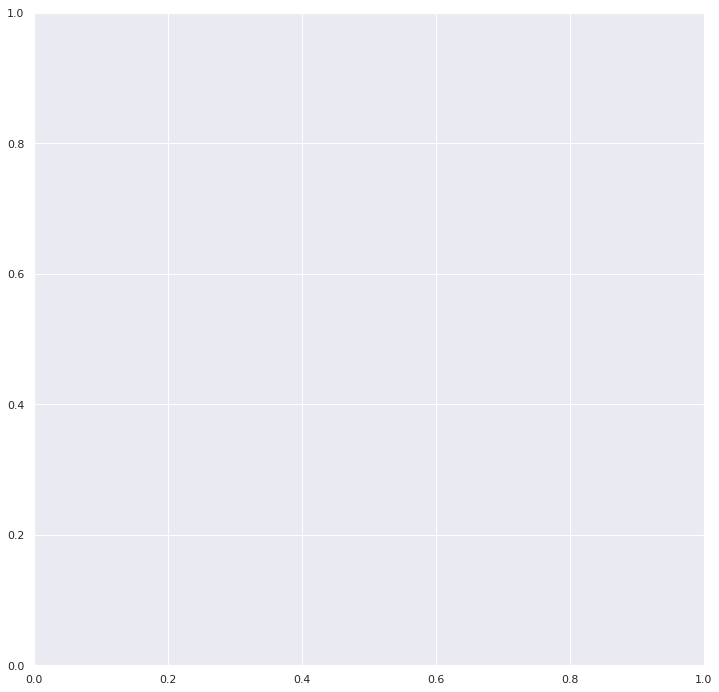

In [206]:
plot_estimator(clf, X_test,y_test, poly)

## Grid Search with Class Weights

In [87]:
from sklearn.model_selection import GridSearchCV

In [81]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
class_weights = np.linspace(0.05, 0.95, 20)
hyperparameters = dict(C=C, penalty=penalty, class_weights=class_weights)

In [89]:
clf = GridSearchCV(pipeline, hyperparameters, scoring='f1', cv=5)